In [1]:
# %load model_weights_cv.py
#!/usr/bin/env python3
"""
Created on Sun May 14 17:08:27 2017

@author: meiyi
"""
# highest lb score 

import pandas as pd
import numpy as np
import platform

def setPath():
    if platform.system() == 'Darwin':
        path_w2v = '/Volumes/MyPassport/kaggle_quora/w2v_pretrained/'
        path_data= '/Volumes/MyPassport/kaggle_quora/data/'
        path_feature = '/Volumes/MyPassport/kaggle_quora/features/'
        path_unpack = '/Volumes/MyPassport/kaggle_quora/features/un_pack/'
        return path_w2v,path_data,path_feature,path_unpack
    elif platform.system() == 'Darwin':
        path_w2v = 'D:\\kaggle_quora\\w2v_pretrained\\'
        path_data= 'D:\\kaggle_quora\\data\\'
        path_feature = 'D:\\kaggle_quora\\features\\'
        return path_w2v,path_data,path_feature,path_unpack
        
path_w2v,path_data,path_feature,path_unpack = setPath()


# basic features ---- features engineering

test_data = pd.DataFrame()

for i in range(0,10):
    filename = 'test_'+str(i)+'_quora_features.pkl'
    data = pd.read_pickle(path_feature+filename)
    test_data = test_data.append(data)
    
    
train_data = pd.read_pickle(path_feature + 'train_quora_features.pkl')


#train_w2v_q1 = np.load(path_feature+'train_q1_w2v_google.pkl')
#train_w2v_q1 = pd.DataFrame(train_w2v_q1,columns=['q1_' + i for i in list(map(str,range(0,train_w2v_q1.shape[1])))])
#  
#train_w2v_q2 = np.load(path_feature+'train_q2_w2v_google.pkl')
#train_w2v_q2 = pd.DataFrame(train_w2v_q2,columns=['q2_' + i for i in list(map(str,range(0,train_w2v_q2.shape[1])))])

train_porter_intersec = pd.DataFrame(pd.read_pickle(path_feature+'train_porter_interaction.pkl'),
                                     columns = ['porter_intersec'])
test_porter_intersec = pd.DataFrame(pd.read_pickle(path_feature+'test_porter_interaction.pkl'),
                                     columns = ['porter_intersec'])



train_intersec = pd.read_pickle(path_feature + 'train_intersect.pkl')
test_intersec = pd.read_pickle(path_feature + 'test_intersect.pkl')


# magic features 

train_comb = pd.read_pickle(path_feature+'magic_feature_train.pkl')
test_comb = pd.read_pickle(path_feature+'magic_feature_test.pkl')


# features stacking
 

train_data['weights']= [ np.random.uniform(0.2,0.3) if x == 1 else
                         np.random.uniform(0.8,0.9) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test

sub.to_csv(path_data+'xgb_2105_0.2_0.8_0.9_9_intersec.csv', index=False)


/Users/meiyi/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-logloss:0.677833	valid-logloss:0.677893
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.552853	valid-logloss:0.553475
[20]	train-logloss:0.464234	valid-logloss:0.465473
[30]	train-logloss:0.399395	valid-logloss:0.401221
[40]	train-logloss:0.350815	valid-logloss:0.353216
[50]	train-logloss:0.313729	valid-logloss:0.316651
[60]	train-logloss:0.285143	valid-logloss:0.28858
[70]	train-logloss:0.262832	valid-logloss:0.266786
[80]	train-logloss:0.245124	valid-logloss:0.249569
[90]	train-logloss:0.231221	valid-logloss:0.236132
[100]	train-logloss:0.22023	valid-logloss:0.225554
[110]	train-logloss:0.211406	valid-logloss:0.217139
[120]	train-logloss:0.204364	valid-logloss:0.210496
[130]	train-logloss:0.198705	valid-logloss:0.205245
[140]	train-logloss:0.194118	valid-logloss:0.201026
[150]	train-logloss:0.190371	valid-logloss:0.197654
[160]	train-logloss:0.18721	val

In [2]:
train_data['weights']= [ np.random.uniform(0.2,0.25) if x == 1 else
                         np.random.uniform(0.8,0.85) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test

sub.to_csv(path_data+'xgb_2105_0.2_0.25_0.8_0.85_9_intersec_no_hash.csv', index=False)


[0]	train-logloss:0.677646	valid-logloss:0.677689
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.551037	valid-logloss:0.551491
[20]	train-logloss:0.461442	valid-logloss:0.462323
[30]	train-logloss:0.395853	valid-logloss:0.397189
[40]	train-logloss:0.346675	valid-logloss:0.348455
[50]	train-logloss:0.309152	valid-logloss:0.311406
[60]	train-logloss:0.280101	valid-logloss:0.282818
[70]	train-logloss:0.257462	valid-logloss:0.260636
[80]	train-logloss:0.239581	valid-logloss:0.24319
[90]	train-logloss:0.225486	valid-logloss:0.229514
[100]	train-logloss:0.214327	valid-logloss:0.218799
[110]	train-logloss:0.20536	valid-logloss:0.210279
[120]	train-logloss:0.198176	valid-logloss:0.203526
[130]	train-logloss:0.192447	valid-logloss:0.198186
[140]	train-logloss:0.187783	valid-logloss:0.193936
[150]	train-logloss:0.183993	valid-logloss:0.190548
[160]	train-logloss:0.180842	va

In [ ]:
train_data['weights']= [ np.random.uniform(0.2,0.21) if x == 1 else
                         np.random.uniform(0.8,0.81) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test

sub.to_csv(path_data+'xgb_2105_0.2_0.21_0.8_0.81_9_intersec_no_hash.csv', index=False)


[0]	train-logloss:0.677463	valid-logloss:0.677531
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.549474	valid-logloss:0.550142
[20]	train-logloss:0.458835	valid-logloss:0.460006
[30]	train-logloss:0.392464	valid-logloss:0.394087
[40]	train-logloss:0.342687	valid-logloss:0.344739
[50]	train-logloss:0.304731	valid-logloss:0.307191
[60]	train-logloss:0.275466	valid-logloss:0.278321
[70]	train-logloss:0.252635	valid-logloss:0.25586
[80]	train-logloss:0.234594	valid-logloss:0.238197
[90]	train-logloss:0.220373	valid-logloss:0.224344
[100]	train-logloss:0.209174	valid-logloss:0.213464
[110]	train-logloss:0.200281	valid-logloss:0.204916
[120]	train-logloss:0.192948	valid-logloss:0.198
[130]	train-logloss:0.187103	valid-logloss:0.192523
[140]	train-logloss:0.182367	valid-logloss:0.188141
[150]	train-logloss:0.178535	valid-logloss:0.184681
[160]	train-logloss:0.175433	vali

In [5]:
train_data['weights']= [ np.random.uniform(0.1,0.11) if x == 1 else
                         np.random.uniform(0.9,0.91) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test

sub.to_csv(path_data+'xgb_2105_0.1_0.11_0.9_0.91_9_intersec_no_hash.csv', index=False)


[0]	train-logloss:0.675765	valid-logloss:0.675808
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.533886	valid-logloss:0.534324
[20]	train-logloss:0.433372	valid-logloss:0.434197
[30]	train-logloss:0.359549	valid-logloss:0.360719
[40]	train-logloss:0.303976	valid-logloss:0.305481
[50]	train-logloss:0.261415	valid-logloss:0.263308
[60]	train-logloss:0.228507	valid-logloss:0.230786
[70]	train-logloss:0.202831	valid-logloss:0.205456
[80]	train-logloss:0.18266	valid-logloss:0.185572
[90]	train-logloss:0.166794	valid-logloss:0.169969
[100]	train-logloss:0.154238	valid-logloss:0.157664
[110]	train-logloss:0.144262	valid-logloss:0.147934
[120]	train-logloss:0.136302	valid-logloss:0.140205
[130]	train-logloss:0.12989	valid-logloss:0.134039
[140]	train-logloss:0.124724	valid-logloss:0.129137
[150]	train-logloss:0.120584	valid-logloss:0.125229
[160]	train-logloss:0.117207	va

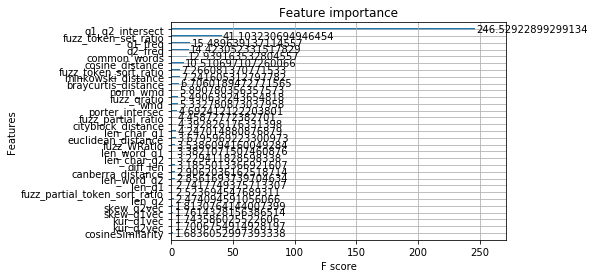

In [24]:
import matplotlib.pyplot as plt
xgb.plot_importance(bst,height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score',
                ylabel='Features', importance_type='gain')
plt.show()

In [30]:

sub.to_csv(path_data+'xgb_2105_0.2_0.9_1_9_intersec_no_hash_without_cosine.csv', index=False)


In [28]:
test_features.shape

(2345796, 34)

In [32]:
train_q1_q2_new_cosine = pd.DataFrame(pd.read_pickle(path_feature+'train_q1_q2_new_cosine.pickle'),columns = ['new_cosine'])
test_q1_q2_new_cosine = pd.DataFrame(pd.read_pickle(path_feature+'test_q1_q2_new_cosine.pickle'),columns = ['new_cosine'])



train_data['weights']= [ np.random.uniform(0.2,0.3) if x == 1 else
                         np.random.uniform(0.8,0.9) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                            train_q1_q2_new_cosine,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                           test_q1_q2_new_cosine,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test


[0]	train-logloss:0.677823	valid-logloss:0.677914
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.552686	valid-logloss:0.553612
[20]	train-logloss:0.464017	valid-logloss:0.465685
[30]	train-logloss:0.399082	valid-logloss:0.401529
[40]	train-logloss:0.350366	valid-logloss:0.353513
[50]	train-logloss:0.313212	valid-logloss:0.317017
[60]	train-logloss:0.284528	valid-logloss:0.288936
[70]	train-logloss:0.262115	valid-logloss:0.267034
[80]	train-logloss:0.24445	valid-logloss:0.249855
[90]	train-logloss:0.23048	valid-logloss:0.236382
[100]	train-logloss:0.219301	valid-logloss:0.22572
[110]	train-logloss:0.210456	valid-logloss:0.217301
[120]	train-logloss:0.203391	valid-logloss:0.210681
[130]	train-logloss:0.197691	valid-logloss:0.205409
[140]	train-logloss:0.193018	valid-logloss:0.201188
[150]	train-logloss:0.18924	valid-logloss:0.197801
[160]	train-logloss:0.186091	vali

In [33]:
sub.to_csv(path_data+'xgb_2105_0.2_0.8_0.1_9_intersec_no_hash_add_new_cosine.csv', index=False)


In [2]:
# %load model_weights_cv.py
#!/usr/bin/env python3
"""
Created on Sun May 14 17:08:27 2017

@author: meiyi
"""
# highest lb score 

import pandas as pd
import numpy as np
import platform

def setPath():
    if platform.system() == 'Darwin':
        path_w2v = '/Volumes/MyPassport/kaggle_quora/w2v_pretrained/'
        path_data= '/Volumes/MyPassport/kaggle_quora/data/'
        path_feature = '/Volumes/MyPassport/kaggle_quora/features/'
        path_unpack = '/Volumes/MyPassport/kaggle_quora/features/un_pack/'
        return path_w2v,path_data,path_feature,path_unpack
    elif platform.system() == 'Darwin':
        path_w2v = 'D:\\kaggle_quora\\w2v_pretrained\\'
        path_data= 'D:\\kaggle_quora\\data\\'
        path_feature = 'D:\\kaggle_quora\\features\\'
        return path_w2v,path_data,path_feature,path_unpack
        
path_w2v,path_data,path_feature,path_unpack = setPath()


# basic features ---- features engineering

test_data = pd.DataFrame()

for i in range(0,10):
    filename = 'test_'+str(i)+'_quora_features.pkl'
    data = pd.read_pickle(path_feature+filename)
    test_data = test_data.append(data)
    
    
train_data = pd.read_pickle(path_feature + 'train_quora_features.pkl')


#train_w2v_q1 = np.load(path_feature+'train_q1_w2v_google.pkl')
#train_w2v_q1 = pd.DataFrame(train_w2v_q1,columns=['q1_' + i for i in list(map(str,range(0,train_w2v_q1.shape[1])))])
#  
#train_w2v_q2 = np.load(path_feature+'train_q2_w2v_google.pkl')
#train_w2v_q2 = pd.DataFrame(train_w2v_q2,columns=['q2_' + i for i in list(map(str,range(0,train_w2v_q2.shape[1])))])

train_porter_intersec = pd.DataFrame(pd.read_pickle(path_feature+'train_porter_interaction.pkl'),
                                     columns = ['porter_intersec'])
test_porter_intersec = pd.DataFrame(pd.read_pickle(path_feature+'test_porter_interaction.pkl'),
                                     columns = ['porter_intersec'])



train_intersec = pd.read_pickle(path_feature + 'train_intersect.pkl')
test_intersec = pd.read_pickle(path_feature + 'test_intersect.pkl')


# magic features 

train_comb = pd.read_pickle(path_feature+'magic_feature_train.pkl')
test_comb = pd.read_pickle(path_feature+'magic_feature_test.pkl')


# features stacking
 



In [3]:
train_data['weights']= [ np.random.uniform(0.2,0.21) if x == 1 else
                         np.random.uniform(0.8,0.81) for x in train_data['is_duplicate']]


train_features = pd.concat([train_data[train_data.columns.difference(['question1', 'question2'])],
                                       train_porter_intersec,
                                       train_intersec,
                             train_comb[train_comb.columns.difference(['id','is_duplicate'])]], axis=1)
    #.tocsr()
    

test_features = pd.concat([test_data[test_data.columns.difference(['question1', 'question2'])],
                                     test_porter_intersec,
                                     test_intersec,
                            test_comb[test_comb.columns.difference(['id'])]],axis=1)
    #.tocsr()
    


from sklearn.model_selection import train_test_split

feature_col = train_features.columns.difference(['id','q1_hash','q2_hash']).values.tolist()

pos_train, pos_test = train_test_split(train_features.ix[train_features['is_duplicate']==1,feature_col], test_size = 0.3)
neg_train, neg_test = train_test_split(train_features.ix[train_features['is_duplicate']==0,feature_col], test_size = 0.3)

train_X = pos_train.append(neg_train)
test_X = pos_test.append(neg_test)

train_y = train_X.is_duplicate.values
weight_X = train_X.weights.values
train_X = train_X[train_X.columns.difference(['is_duplicate','weights'])]

test_y = test_X.is_duplicate.values
weight_x = test_X.weights.values
test_X = test_X[test_X.columns.difference(['is_duplicate','weights'])]

# Set our parameters for xgboost

import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 9

d_train = xgb.DMatrix(train_X, label=train_y,weight=weight_X)
d_valid = xgb.DMatrix(test_X, label=test_y,weight=weight_x) 

watchlist = [(d_train, 'train'), (d_valid, 'valid')]


bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=5, verbose_eval=10)
               # , feval = kappa)

feature_col_test = train_X.columns.values.tolist()

d_test = xgb.DMatrix(test_features.ix[:,feature_col_test])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_comb['id']
sub['is_duplicate'] = p_test

sub.to_csv(path_data+'xgb_2105_0.15_0.95_9_intersec.csv', index=False)

[0]	train-logloss:0.676415	valid-logloss:0.676474
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.539837	valid-logloss:0.540414
[20]	train-logloss:0.443114	valid-logloss:0.444105
[30]	train-logloss:0.37214	valid-logloss:0.373502
[40]	train-logloss:0.318839	valid-logloss:0.320614
[50]	train-logloss:0.278124	valid-logloss:0.280266
[60]	train-logloss:0.246675	valid-logloss:0.249161
[70]	train-logloss:0.222167	valid-logloss:0.224959
[80]	train-logloss:0.20284	valid-logloss:0.205916
[90]	train-logloss:0.187635	valid-logloss:0.191008
[100]	train-logloss:0.175623	valid-logloss:0.179281
[110]	train-logloss:0.16608	valid-logloss:0.169997
[120]	train-logloss:0.158411	valid-logloss:0.162627
[130]	train-logloss:0.152238	valid-logloss:0.156765
[140]	train-logloss:0.14728	valid-logloss:0.152074
[150]	train-logloss:0.143221	valid-logloss:0.148308
[160]	train-logloss:0.139868	vali

In [4]:
train_data.head(10)

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,weights
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,...,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301,0.959613
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,...,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444,0.956089
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,...,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131,0.953827
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,9,...,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568,0.950825
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,7,...,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876,0.952368
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,-4,26,27,16,16,...,1.0,150.335589,0.741946,0.337470,0.400061,0.102946,-0.077741,-0.335505,-0.057847,0.156813
6,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,-43,14,20,4,11,...,1.0,200.598725,1.281122,0.597082,0.816676,-0.090366,-0.000266,0.296892,0.130717,0.951383
7,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,-11,16,16,7,9,...,1.0,95.395891,0.359486,0.161125,0.187150,0.346824,0.368469,0.635773,0.865446,0.155763
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,-6,16,16,8,8,...,0.0,0.000000,0.000000,0.000000,0.000000,0.202336,0.202336,-0.434927,-0.434927,0.959617
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,25,24,9,9,...,1.0,153.647611,0.754599,0.337939,0.409126,0.120050,0.204449,-0.214573,-0.126814,0.954638


In [ ]:
import sys
from gensim.models import word2vec


train_w2v_q1 = np.load(path_feature+'train_q1_w2v_google.pkl')
train_w2v_q1 = pd.DataFrame(train_w2v_q1,columns=['q1_' + i for i in list(map(str,range(0,train_w2v_q1.shape[1])))])
  
train_w2v_q2 = np.load(path_feature+'train_q2_w2v_google.pkl')
train_w2v_q2 = pd.DataFrame(train_w2v_q2,columns=['q2_' + i for i in list(map(str,range(0,train_w2v_q2.shape[1])))])


In [5]:
train_w2v_q1 = np.load(path_feature+'train_q1_w2v_google.pkl')

In [7]:
train_w2v_q2 = np.load(path_feature+'train_q2_w2v_google.pkl')

In [9]:
train_w2v_q2

array([[-0.06372326,  0.01629744, -0.01969495, ...,  0.07126812,
         0.03986768, -0.01777058],
       [-0.0638314 ,  0.06023106,  0.03145551, ..., -0.03841253,
         0.04433751, -0.05794364],
       [ 0.00078818,  0.00838199, -0.03413426, ..., -0.01732291,
        -0.08087941, -0.02825323],
       ..., 
       [-0.01541002,  0.05360006, -0.03930671, ...,  0.01347446,
         0.02799114, -0.00032104],
       [ 0.04522298,  0.082693  ,  0.04575336, ...,  0.04280505,
        -0.0033227 , -0.00439151],
       [ 0.0253418 ,  0.00810537,  0.02050422, ..., -0.04502985,
        -0.0505335 ,  0.09045997]])